In [1]:
from astropy.modeling import models, fitting

from scipy.optimize import minimize

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import emcee
import corner

In [2]:
lc_c = pd.read_csv('./lc_c.csv',delimiter=',');
lc_c =  lc_c.iloc[:, 1:-1];
x = np.linspace(lc_c.iloc[0,0], lc_c.iloc[-1,0], num=100);

In [3]:
p_init = models.BrokenPowerLaw1D(amplitude=2, x_break=19, alpha_1=0.7, alpha_2=-1); ## init power law
fit_p = fitting.LevMarLSQFitter(); ## which fitter to use
p = fit_p(p_init, lc_c.iloc[:,0], lc_c.iloc[:,2], maxiter=10000); ## fit the data



<BrokenPowerLaw1D(amplitude=4.3474276, x_break=18.7761854, alpha_1=-7.73164493, alpha_2=1.54700918)>

In [4]:
t = lc_c['Day'];
y = lc_c['Flux'];
yerr = lc_c['Error'];


def broken_powerlaw(t, t_b, s, beta_1, beta_2, F_c):
    #Granot & sari 2002
    
    a = (t/t_b)**(-s*beta_1);
    b = (t/t_b)**(-s*beta_2);

    F_nu = F_c*(a+b)**(-1/s);
    
    return F_nu
    

def log_likelihood(theta, t, y, yerr):
    t_b, s, beta_1, beta_2, F_c = theta;
    #Granot & sari 2002
    model = broken_powerlaw(t, t_b, s, beta_1, beta_2, F_c);
    
    return -0.5 * np.sum((y - model) ** 2 / yerr + np.log(yerr))

nll = lambda *args: -log_likelihood(*args);

initial = np.array([p.x_break.value, 1., p.alpha_1.value, p.alpha_2.value, p.amplitude.value]);
initial = np.array(initial, dtype=np.float128);

soln = minimize(nll, initial, args=(t, y, yerr));
t_bml, s_ml, beta_1ml, beta_2ml, F_cml = soln.x;


# print(t_bml, s_ml, beta_1ml, beta_2ml, F_cml);
newy = broken_powerlaw(x, t_bml, beta_1ml, beta_2ml, s_ml, F_cml);


/var/folders/k8/d570h55x0jddd1svnvdqq5m40000gn/T/ipykernel_35064/2530967915.py:9: RuntimeWarning: overflow encountered in power
  a = (t/t_b)**(-s*beta_1);


In [5]:
def log_prior(theta):
    t_b, s, beta_1, beta_2, F_c = theta;

    if -p.x_break.value < t_b < p.x_break.value  and -1 < s < 1 and -p.alpha_1.value < beta_1 < p.alpha_2.value and -p.alpha_2.value < beta_2 < p.alpha_2.value and -p.amplitude.value < F_c < p.amplitude.value:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)



In [6]:
pos = soln.x + 1e-4*np.random.randn(32, 5);
nwalkers, ndim = pos.shape;

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr));

sampler.run_mcmc(pos, 100, progress=True);

  0%|          | 0/100 [00:00<?, ?it/s]/Users/mwilliam/astro/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:00<00:00, 1302.96it/s]


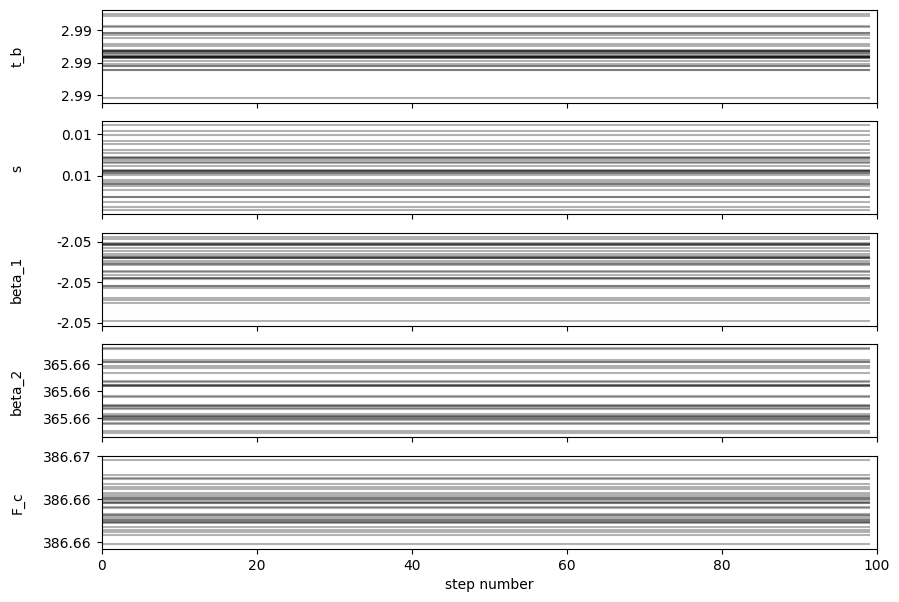

In [7]:
#check sampler
# plt.style.use('default');
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True);

samples = sampler.get_chain();

labels = ["t_b", "s", "beta_1", "beta_2", "F_c"];


for i in range(ndim):
    ax = axes[i]
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'));
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");